In [1]:
import os
import sys
sys.path.append('../') 
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd


import random
import copy
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map  

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BartForConditionalGeneration, BartConfig
from collections import OrderedDict
import torch
from torch import nn

from demo.ConfSeq import get_ConfSeq_pair_from_mol,get_mol_from_ConfSeq_pair,randomize_mol
from rdkit.Chem import rdmolops, rdchem

/home/xiongjiacheng/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
vocab = [chr(i) for i in range(33, 127)] 

for i in range(-180,180):
    vocab.append('<'+str(i)+'>')

vocab.append('<mask>')
vocab.append('<unk>')
vocab.append('<sos>')
vocab.append('<eos>')
vocab.append('<pad>')


config = BartConfig()

config.pad_token_id = vocab.index('<pad>')
config.eos_token_id = vocab.index('<eos>')
config.sos_token_id = vocab.index('<sos>')
config.forced_eos_token_id = None
config.encoder_layers = 6
config.encoder_attention_heads = 8
config.decoder_layers = 0
config.decoder_attention_heads = 0
config.d_model = 256
# config.share_embeddings = True
config.vocab_size = len(vocab)


vocab_dict = {char: idx for idx, char in enumerate(vocab)}
bart = BartForConditionalGeneration(config = config )


class CustomBartEncoder(nn.Module):
    def __init__(self, bart):
        super().__init__()
    
        # 加载 BART 模型
        self.bart_model = bart 
        
    def forward(self, input_ids, attention_mask=None):
        # 获取编码器输出
        outputs = self.bart_model.model.encoder(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state

# 示例使用
bart_encoder_model  = CustomBartEncoder(bart)
bart_encoder_model.eval()

CustomBartEncoder(
  (bart_model): BartForConditionalGeneration(
    (model): BartModel(
      (shared): Embedding(459, 256, padding_idx=458)
      (encoder): BartEncoder(
        (embed_tokens): Embedding(459, 256, padding_idx=458)
        (embed_positions): BartLearnedPositionalEmbedding(1026, 256)
        (layers): ModuleList(
          (0-5): 6 x BartEncoderLayer(
            (self_attn): BartSdpaAttention(
              (k_proj): Linear(in_features=256, out_features=256, bias=True)
              (v_proj): Linear(in_features=256, out_features=256, bias=True)
              (q_proj): Linear(in_features=256, out_features=256, bias=True)
              (out_proj): Linear(in_features=256, out_features=256, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=256, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_feat

In [4]:
def rm_invalid_chirality(mol):
    mol = copy.deepcopy(mol)
    """
    找出分子中同时出现在三个环中的原子。
    
    参数:
        mol: RDKit 分子对象
    返回:
        List[int]: 同时出现在三个环中的原子的索引列表
    """
    # 获取分子的所有环（SSSR：最小集的简单环）
    rings = rdmolops.GetSymmSSSR(mol)

    # 创建一个字典，记录每个原子出现在多少个环中
    atom_in_rings_count = {}

    # 遍历所有环，统计每个原子出现的次数
    for ring in rings:
        for atom_idx in ring:
            if atom_idx not in atom_in_rings_count:
                atom_in_rings_count[atom_idx] = 0
            atom_in_rings_count[atom_idx] += 1

    # 找出那些同时出现在三个环中的原子
    atoms_in_3_rings = [atom for atom, count in atom_in_rings_count.items() if count == 3]

    for atom_idx in atoms_in_3_rings:
        atom = mol.GetAtomWithIdx(atom_idx)
        atom.SetChiralTag(rdchem.ChiralType.CHI_UNSPECIFIED)

    return mol

In [5]:
def get_ConfSeq(query_mol):

    if query_mol != None:
        try:
            
            query_mol = rm_invalid_chirality(query_mol)
            query_mol = randomize_mol(query_mol)
            Chem.MolToSmiles(query_mol)    
            query_mol = Chem.RenumberAtoms(query_mol, eval(query_mol.GetProp('_smilesAtomOutputOrder'))) 
            Chem.MolToSmiles(query_mol,canonical = False)
            query_mol = Chem.RenumberAtoms(query_mol, eval(query_mol.GetProp('_smilesAtomOutputOrder'))) 
            in_smiles,TD_smiles = get_ConfSeq_pair_from_mol(query_mol)
            TD_smiles = TD_smiles.replace('<180>','<-180>')
        
        except:
            in_smiles,TD_smiles = '',''            
    else:
        in_smiles,TD_smiles = '',''
        
    return TD_smiles

In [6]:
class TensorDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.Tensor(self.data[idx]).long()

def collate_fn(batch):
    data = batch  # 解压每个样本中的数据和标签
    padded_data = pad_sequence(data, batch_first=True, padding_value = vocab.index('<pad>'))  # 对数据进行填充
    return padded_data


def mean_pooling(last_hidden_state, attention_mask):
    # 对每个样本进行池化，忽略 pad 的位置
    # 将 attention_mask 转换为 float 类型，并进行扩展
    attention_mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
    # 计算有效的特征总和和有效特征的数量
    sum_embeddings = (last_hidden_state * attention_mask).sum(dim=1)
    sum_mask = attention_mask.sum(dim=1)
    # 计算平均池化，避免除以零
    pooled_output = sum_embeddings / (sum_mask + 1e-8)  # 加小常数以避免除零
    return pooled_output

In [7]:
input_ids = torch.randint(0, 188, (2, 33))  # 示例输入 (batch_size=2, seq_length=33)
attention_mask = torch.ones(input_ids.shape)  # 创建一个注意力掩码
encoder_outputs = bart_encoder_model(input_ids, attention_mask)

In [8]:
checkpoint = torch.load('./checkpoints/model_epoch_1.pth', map_location='cpu')  # 使用适当的设备

new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    if k.startswith('module.'):
        # 去掉前缀 'module.'
        new_state_dict[k[7:]] = v
    else:
        new_state_dict[k] = v

bart_encoder_model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [9]:
device = torch.device('cuda')

In [10]:
def neutralize_charge(mol):
    """
    检查分子中是否有带电荷的原子。如果有，且该原子没有邻居原子带相反电荷，
    则将该原子的电荷设为 0，并调整相应的氢的数目。

    参数:
        mol (rdkit.Chem.Mol): 输入的分子对象。

    返回:
        rdkit.Chem.Mol: 经过处理的分子对象。
    """
    # 检查每个原子的电荷
    for atom in mol.GetAtoms():
        charge = atom.GetFormalCharge()
        num_h = atom.GetNumExplicitHs()

        # 条件: 原子负电荷，或原子正电荷且其氢数目多于电荷数
        if charge < 0 or (charge > 0 and num_h >= charge):
        #if charge != 0:  # 如果原子带电荷
            has_opposite_neighbor = False

            # 检查邻居是否有带相反电荷的原子
            for neighbor in atom.GetNeighbors():
                neighbor_charge = neighbor.GetFormalCharge()
                if neighbor_charge == -charge:
                    has_opposite_neighbor = True
                    break

            if not has_opposite_neighbor:  # 如果没有邻居带相反电荷
                # 将原子电荷设为 0
                atom.SetFormalCharge(0)
                #print(atom.GetNumExplicitHs())
                # 调整氢原子的数目
                if charge > 0:
                    # 原子原本带正电荷，需要增加相应数量的氢
                    atom.SetNumExplicitHs(atom.GetNumExplicitHs() - charge)
                elif charge < 0:
                    # 原子原本带负电荷，需要减少相应数量的氢
                    atom.SetNumExplicitHs(atom.GetNumExplicitHs() - charge)

    # 更新分子状态
    Chem.SanitizeMol(mol)
    return mol

In [11]:
suppl = Chem.SDMolSupplier('./data/PDB/unique_hiqbind_mol.sdf')
unique_mol_lis = [mol for mol in suppl if mol]

In [12]:
encoded_seqs = process_map(get_ConfSeq, tqdm(unique_mol_lis), max_workers=32)
print('encoded_seqs length:', len(encoded_seqs))

encoded_seqs = [i if i != '' else '*' for i in encoded_seqs]
encoded_ints = [[vocab_dict[i] for i in seq.split(' ')] for seq in encoded_seqs]
encoded_dataset = TensorDataset(encoded_ints)
encoded_dataloader = DataLoader(encoded_dataset, batch_size=128, collate_fn=collate_fn)
bart_encoder_model.to(device)
encoded_embeds = []

with torch.no_grad():
    for input_ids in encoded_dataloader:
        input_ids = input_ids.to(device)
        attention_mask = (input_ids != vocab.index('<pad>')).long()  # 创建 attention mask
        # 编码
        output = bart_encoder_model(input_ids, attention_mask)
        pooled_output = mean_pooling(output, attention_mask)
        encoded_embeds.append(pooled_output)

encoded_embeds = torch.cat(tuple(encoded_embeds), dim=0).to('cpu')

  0%|                                                    | 0/9899 [00:00<?, ?it/s]/tmp/ipykernel_2669694/254157558.py:1: TqdmWarning: Iterable length 9899 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  encoded_seqs = process_map(get_ConfSeq, tqdm(unique_mol_lis), max_workers=32)
100%|███████████████████████████████████████| 9899/9899 [00:04<00:00, 2356.44it/s]


encoded_seqs length: 9899


In [13]:
data_np = encoded_embeds
pca = PCA(n_components=2)
data_pca_embed = pca.fit_transform(data_np)

In [14]:
df = pd.read_csv('./data/PDB/PDB_data.csv')
df['embed_x'] = data_pca_embed[:, 0].tolist()
df['embed_y'] = data_pca_embed[:, 1].tolist()

In [15]:
a = list(set(df['class']))
k  = [i for i in a if 'protein kinase' in str(i)]

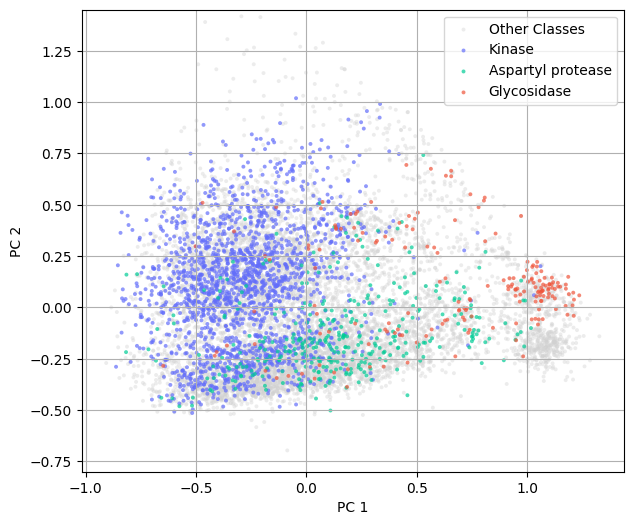

In [16]:
first_label = k
second_label = ['Aspartyl protease\tHydrolase\tProtease']      # 示例的第二类
third_label = ['Glycosidase\tHydrolase']     # 示例的第三类

# 创建布尔数组
is_first_class = df['class'].isin(first_label)
is_second_class = df['class'].isin(second_label)
is_third_class = df['class'].isin(third_label)

# 绘图
plt.figure(figsize=(7, 6))

# 其他类别
plt.scatter(df.loc[~(is_first_class | is_second_class | is_third_class), 'embed_x'], 
            df.loc[~(is_first_class | is_second_class | is_third_class), 'embed_y'], 
            c='#D1D1D1', alpha=0.4, s=8, label="Other Classes",edgecolors='none')

# 第一类
plt.scatter(df.loc[is_first_class, 'embed_x'], df.loc[is_first_class, 'embed_y'], 
            c='#636EFA', alpha=0.7, s=8, label="Kinase",edgecolors='none')

# 第二类
plt.scatter(df.loc[is_second_class, 'embed_x'], df.loc[is_second_class, 'embed_y'], 
            c='#00CC96', alpha=0.7, s=8, label="Aspartyl protease",edgecolors='none')

# 第三类
plt.scatter(df.loc[is_third_class, 'embed_x'], df.loc[is_third_class, 'embed_y'], 
            c='#EF553B', alpha=0.7, s=8, label="Glycosidase",edgecolors='none')

# 添加图例
plt.legend( loc="best")

# 添加标签和标题
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.ylim(-0.8,1.45)

plt.grid(True)
plt.show()
